In [1]:
import os
import torch
import numpy as np
import shutil

In [2]:
import importlib
import sys
import matplotlib.pyplot as plt

sys.path.append('.')  # Add the parent directory to the Python path
import params
importlib.reload(params)

<module 'params' from 'C:\\Users\\BHARGAV BADE\\Multivar LSTM\\params.py'>

In [3]:
#print(params.window_size)
print(params.n_steps_in)

196


In [4]:
print(params.hidden_size)


20


In [5]:
#Study Folder creation for saving Results and Plots
sys.path.append('./Others') 
import study_folder
importlib.reload(study_folder)
study_folder, train_folder, test_folder, val_folder = study_folder.create_study_folder()
print(study_folder)
print(train_folder)

./Results\LSTMStudy_20241023_132350
./Results\LSTMStudy_20241023_132350\Train


In [6]:
#saving the params file used for this study in this study folder

# Path to the config.py file in your project directory
config_file_path = './params.py'

# Destination where the config.py file will be copied (inside the study folder)
config_destination_path = os.path.join(study_folder, 'params.py')

# Copy the config.py file to the study folder
shutil.copy(config_file_path, config_destination_path)

print(f'Config file saved to: {config_destination_path}')


Config file saved to: ./Results\LSTMStudy_20241023_132350\params.py


In [7]:
import sys
sys.path.append('./Data')  # Add the current directory to Python path
import prepare_data01
importlib.reload(prepare_data01)
from prepare_data01 import DataPreparer

In [8]:
# Create an instance of DataPreparer
data_preparer = DataPreparer(data_dir='./01_PM2.5 Chinese Weather data')

In [9]:
# Prepare the data (loads, cleans, splits, and creates tensors)
data_preparer.prepare_data()

# Get the tensors
train_data_tensor, train_labels_tensor, val_data_tensor, val_labels_tensor, test_data_tensor, test_labels_tensor, scaler, pm_index = data_preparer.get_tensors()


print('PM index during scaling is:',pm_index)
# Now you can use these tensors for training in your notebook
print("Train data tensor shape:", train_data_tensor.shape)
print("Train labels tensor shape:", train_labels_tensor.shape)

print("Val data tensor shape:", val_data_tensor.shape)
print("Val labels tensor shape:", val_labels_tensor.shape)

print("Test data tensor shape:", test_data_tensor.shape)
print("Test labels tensor shape:", test_labels_tensor.shape)

./01_PM2.5 Chinese Weather data\BeijingPM20100101_20151231.csv
PM index during scaling is: 4
Train data tensor shape: torch.Size([30216, 196, 15])
Train labels tensor shape: torch.Size([30216, 4])
Val data tensor shape: torch.Size([4871, 196, 15])
Val labels tensor shape: torch.Size([4871, 4])
Test data tensor shape: torch.Size([15009, 196, 15])
Test labels tensor shape: torch.Size([15009, 4])


In [10]:
import torch.nn as nn
import torch.optim as optim

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc_1 = nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, output_size) # fully connected last layer
        self.relu = nn.ReLU()

        # Fully connected layer (for output)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate the LSTM
        output, (hn, cn) = self.lstm(x, (h0, c0))

        # Use the output of the last time step (not all layers or flattened output)
        out = output[:, -1, :]  # take the last output of the sequence

        #hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        #out = self.relu(hn)

        out = self.relu(out)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [12]:
# Prepare the datasets and dataloaders

class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data.to(torch.float32)
        self.labels = labels.to(torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Train Data and Train Labels
X_train = train_data_tensor.to(torch.float32)
y_train = train_labels_tensor.to(torch.float32)

# Train Dataset and Train Dataloader
train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=params.batch_size, 
                                           shuffle = False, drop_last=True)

# Val Data and Val Labels
X_val = val_data_tensor.to(torch.float32)
y_val = val_labels_tensor.to(torch.float32)

# Val Dataset and Val Dataloader
val_dataset = TimeSeriesDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size = params.batch_size, shuffle=False)

# Test Data and Test Labels
X_test = test_data_tensor.to(torch.float32)
y_test = test_labels_tensor.to(torch.float32)

# Test Dataset and Test Dataloader
test_dataset = TimeSeriesDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=params.batch_size, 
                                          shuffle=False, drop_last=True)

In [13]:
# Define model, loss function, and optimizer
input_size = params.input_size  # number of features
hidden_size = params.hidden_size  # number of hidden units in LSTM
output_size = params.output_size  # output size (1 for regression, could be different for classification)
num_layers = params.num_layers  # number of LSTM layers

model = LSTMModel(input_size, hidden_size, output_size, num_layers)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss and optimizer
criterion = nn.MSELoss()  # For regression, use nn.CrossEntropyLoss() for classification
optimizer = optim.Adam(model.parameters(), lr = params.lr)
#optimizer = optim.Adam(model.parameters(), lr = 0.001)

C:\Users\BHARGAV BADE\miniconda3\envs\pyda3.9\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [14]:
## Randomly select 12 sequences from the training set for plotting
#num_fixed_sequences = 12
#random_indices = torch.randperm(len(X_train))[:num_fixed_sequences]  # Get 12 random indices

## Select the corresponding sequences and labels
#fixed_sequences = X_train[random_indices].to('cuda' if torch.cuda.is_available() else 'cpu')
#fixed_labels = y_train[random_indices].to('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# First 12 sequences in the train data set
num_fixed_sequences = 12

# Select the first 12 sequences and labels
fixed_sequences = X_train[:num_fixed_sequences].to('cuda' if torch.cuda.is_available() else 'cpu')
fixed_labels = y_train[:num_fixed_sequences].to('cuda' if torch.cuda.is_available() else 'cpu')


Epoch [1/100], Loss: 1.0146
Epoch [2/100], Loss: 1.0114
Epoch [3/100], Loss: 1.0082
Epoch [4/100], Loss: 1.0067
Epoch [5/100], Loss: 1.0060
-- Evaluation after Epoch [5/100], Test Loss: 0.9120
Epoch [6/100], Loss: 1.0057
Epoch [7/100], Loss: 1.0056
Epoch [8/100], Loss: 1.0056
Epoch [9/100], Loss: 1.0056
Epoch [10/100], Loss: 1.0056
-- Evaluation after Epoch [10/100], Test Loss: 0.9136
Epoch [11/100], Loss: 1.0056
Epoch [12/100], Loss: 1.0056
Epoch [13/100], Loss: 1.0056
Epoch [14/100], Loss: 1.0056
Epoch [15/100], Loss: 1.0056
-- Evaluation after Epoch [15/100], Test Loss: 0.9136
Epoch [16/100], Loss: 1.0056
Epoch [17/100], Loss: 1.0056
Epoch [18/100], Loss: 1.0056
Epoch [19/100], Loss: 1.0056
Epoch [20/100], Loss: 1.0056
-- Evaluation after Epoch [20/100], Test Loss: 0.9136


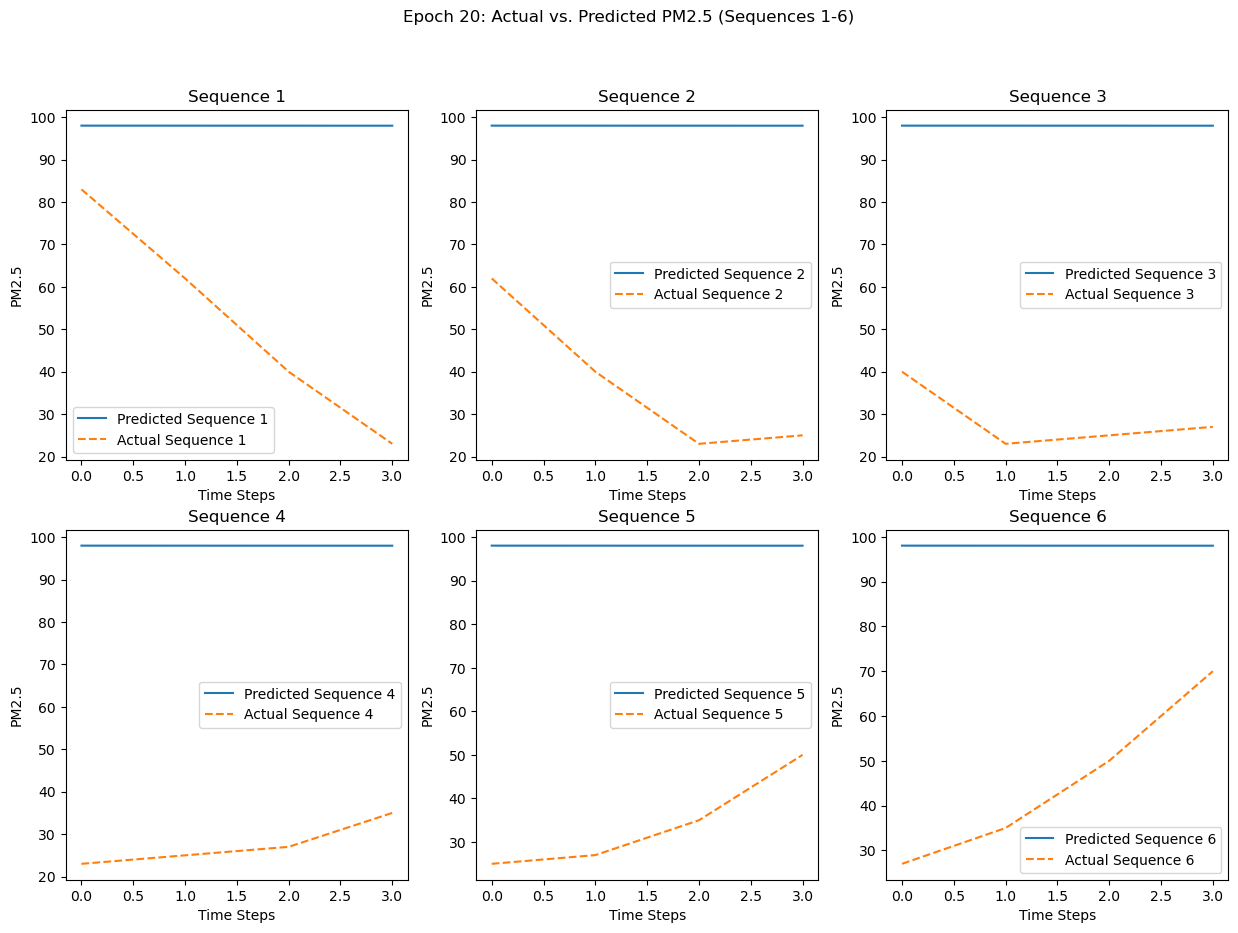

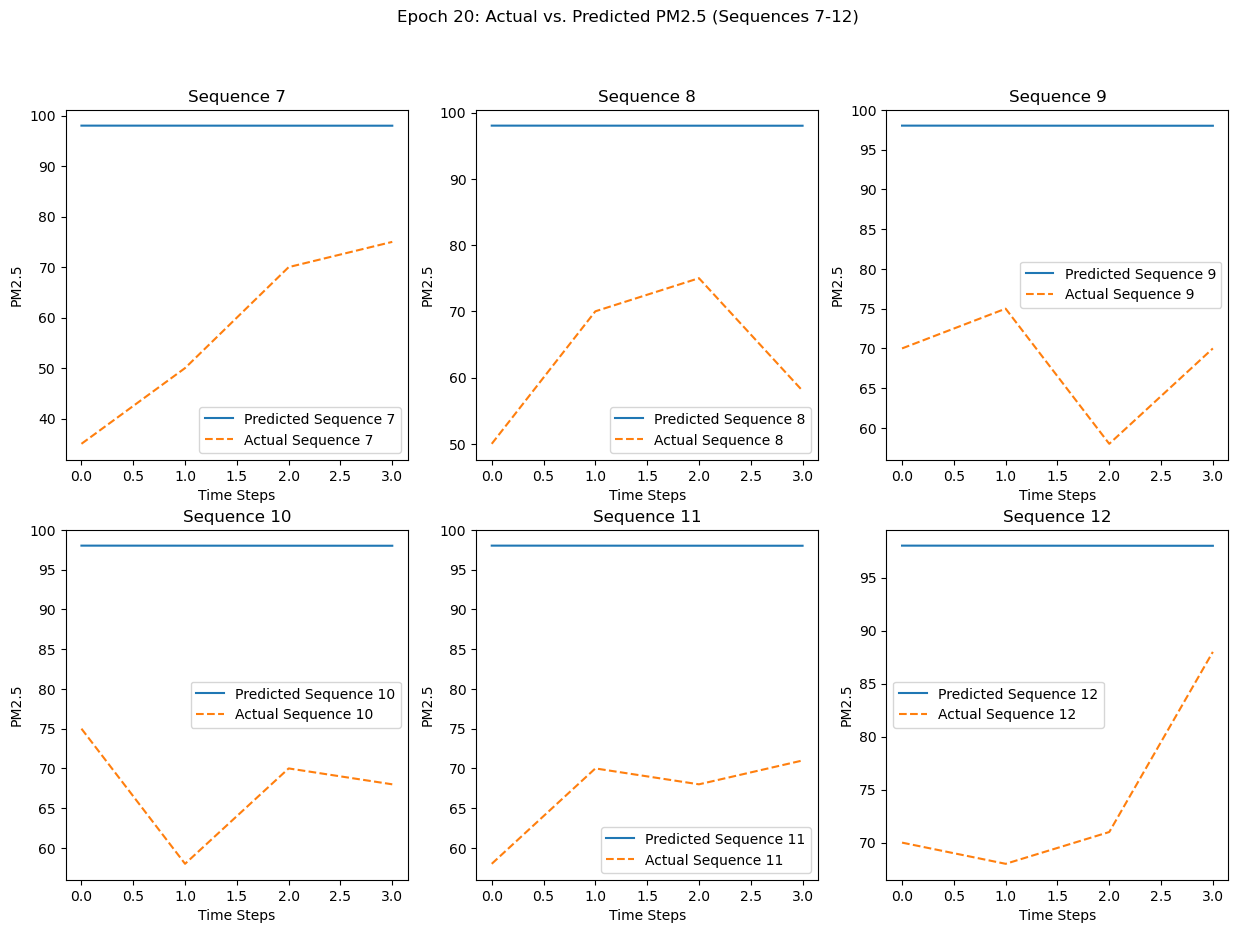

Saved training plots for Epoch 20 in ./Results\LSTMStudy_20241023_132350\Train
Epoch [21/100], Loss: 1.0056
Epoch [22/100], Loss: 1.0056
Epoch [23/100], Loss: 1.0056
Epoch [24/100], Loss: 1.0056
Epoch [25/100], Loss: 1.0056
-- Evaluation after Epoch [25/100], Test Loss: 0.9136
Epoch [26/100], Loss: 1.0056
Epoch [27/100], Loss: 1.0056
Epoch [28/100], Loss: 1.0056
Epoch [29/100], Loss: 1.0056
Epoch [30/100], Loss: 1.0056
-- Evaluation after Epoch [30/100], Test Loss: 0.9136
Epoch [31/100], Loss: 1.0056
Epoch [32/100], Loss: 1.0056
Epoch [33/100], Loss: 1.0056
Epoch [34/100], Loss: 1.0056
Epoch [35/100], Loss: 1.0056
-- Evaluation after Epoch [35/100], Test Loss: 0.9136
Epoch [36/100], Loss: 1.0056
Epoch [37/100], Loss: 1.0056
Epoch [38/100], Loss: 1.0056
Epoch [39/100], Loss: 1.0056
Epoch [40/100], Loss: 1.0056
-- Evaluation after Epoch [40/100], Test Loss: 0.9136


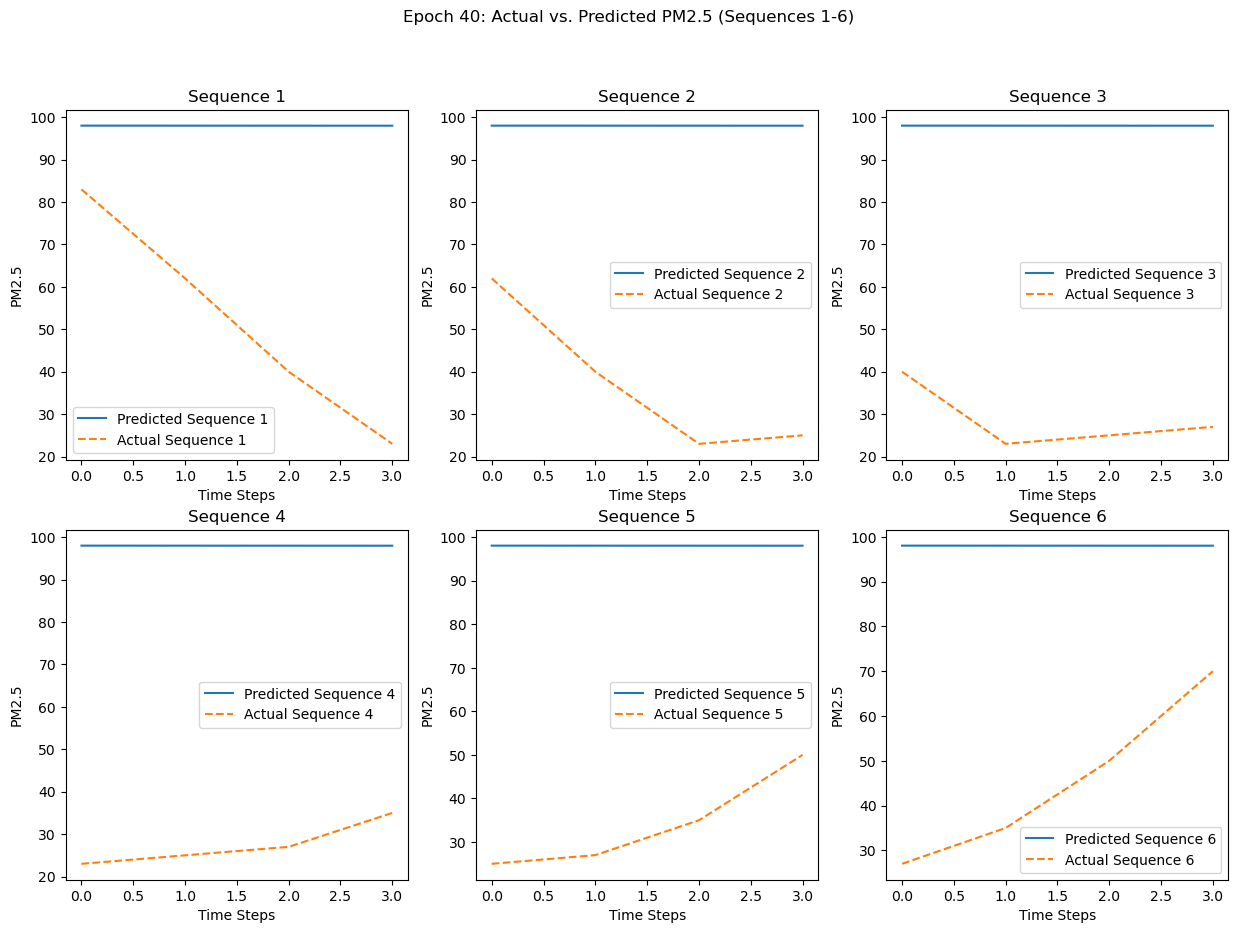

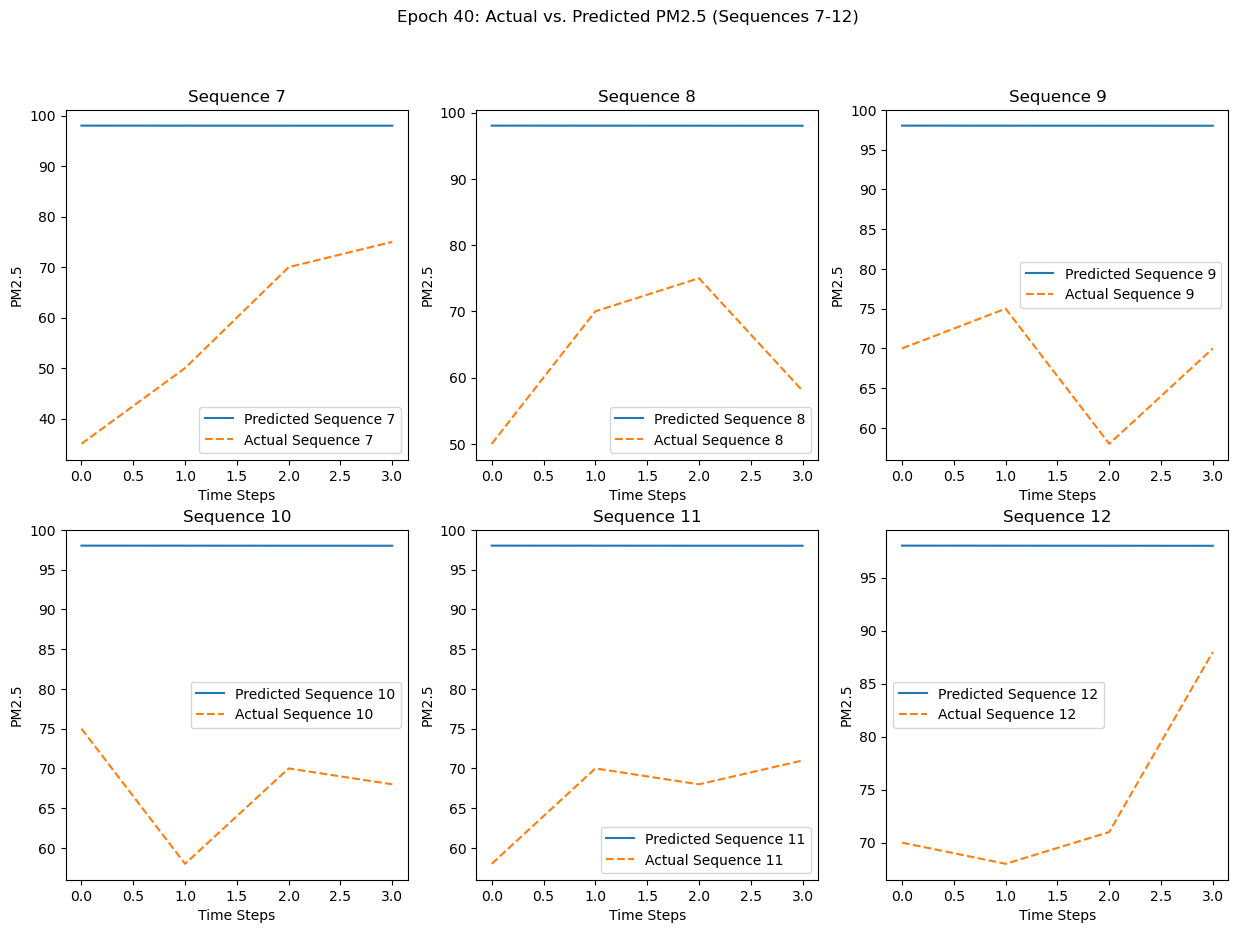

Saved training plots for Epoch 40 in ./Results\LSTMStudy_20241023_132350\Train
Epoch [41/100], Loss: 1.0056
Epoch [42/100], Loss: 1.0056
Epoch [43/100], Loss: 1.0056
Epoch [44/100], Loss: 1.0056
Epoch [45/100], Loss: 1.0056
-- Evaluation after Epoch [45/100], Test Loss: 0.9136
Epoch [46/100], Loss: 1.0056
Epoch [47/100], Loss: 1.0056
Epoch [48/100], Loss: 1.0056
Epoch [49/100], Loss: 1.0056
Epoch [50/100], Loss: 1.0056
-- Evaluation after Epoch [50/100], Test Loss: 0.9136
Epoch [51/100], Loss: 1.0056
Epoch [52/100], Loss: 1.0056
Epoch [53/100], Loss: 1.0056
Epoch [54/100], Loss: 1.0056
Epoch [55/100], Loss: 1.0056
-- Evaluation after Epoch [55/100], Test Loss: 0.9136
Epoch [56/100], Loss: 1.0056
Epoch [57/100], Loss: 1.0056
Epoch [58/100], Loss: 1.0056
Epoch [59/100], Loss: 1.0056
Epoch [60/100], Loss: 1.0056
-- Evaluation after Epoch [60/100], Test Loss: 0.9136


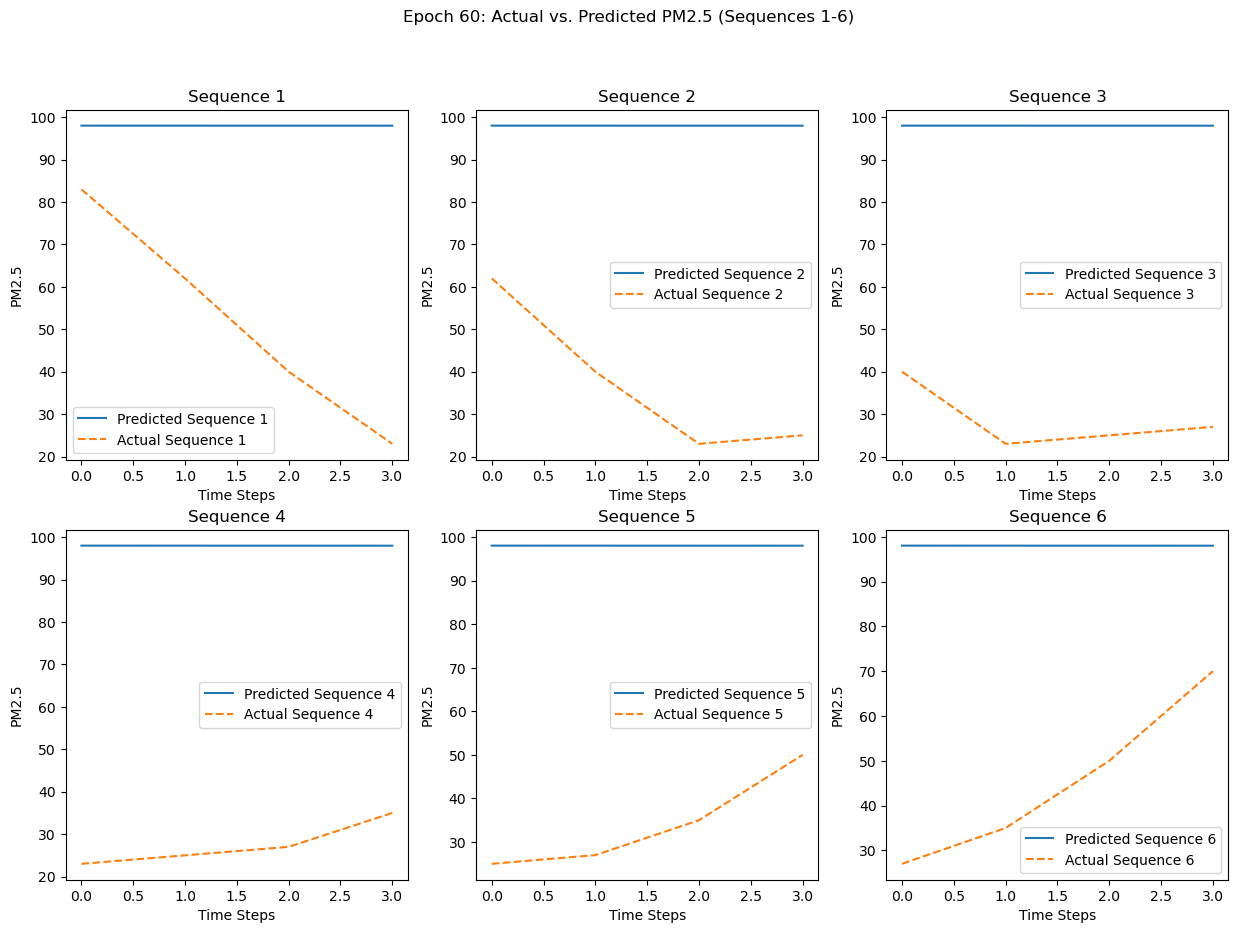

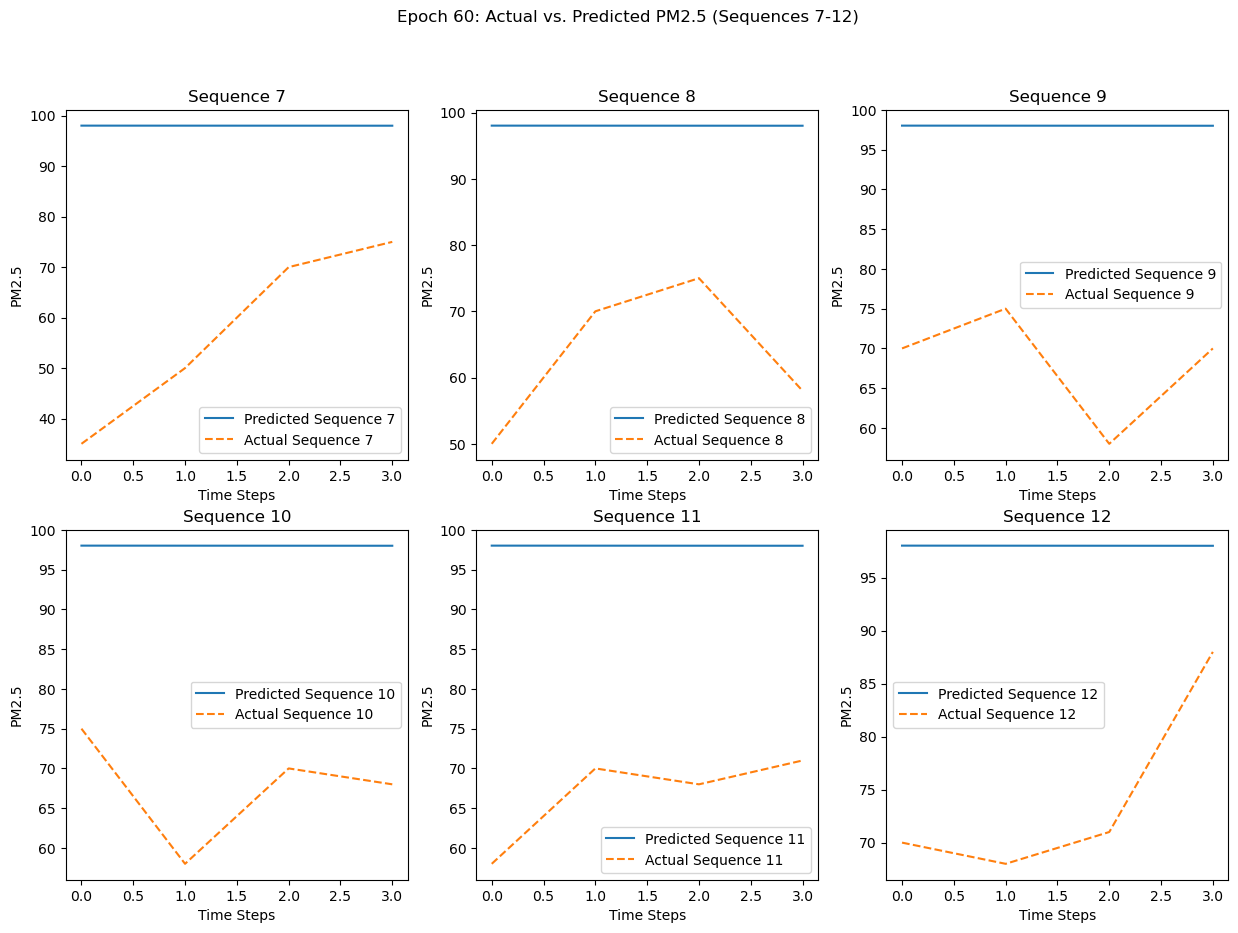

Saved training plots for Epoch 60 in ./Results\LSTMStudy_20241023_132350\Train
Epoch [61/100], Loss: 1.0056
Epoch [62/100], Loss: 1.0056
Epoch [63/100], Loss: 1.0056
Epoch [64/100], Loss: 1.0056
Epoch [65/100], Loss: 1.0056
-- Evaluation after Epoch [65/100], Test Loss: 0.9136
Epoch [66/100], Loss: 1.0056
Epoch [67/100], Loss: 1.0056
Epoch [68/100], Loss: 1.0056
Epoch [69/100], Loss: 1.0056
Epoch [70/100], Loss: 1.0056
-- Evaluation after Epoch [70/100], Test Loss: 0.9136
Epoch [71/100], Loss: 1.0056
Epoch [72/100], Loss: 1.0056
Epoch [73/100], Loss: 1.0056
Epoch [74/100], Loss: 1.0056
Epoch [75/100], Loss: 1.0056
-- Evaluation after Epoch [75/100], Test Loss: 0.9136
Epoch [76/100], Loss: 1.0056
Epoch [77/100], Loss: 1.0056
Epoch [78/100], Loss: 1.0056
Epoch [79/100], Loss: 1.0056
Epoch [80/100], Loss: 1.0056
-- Evaluation after Epoch [80/100], Test Loss: 0.9136


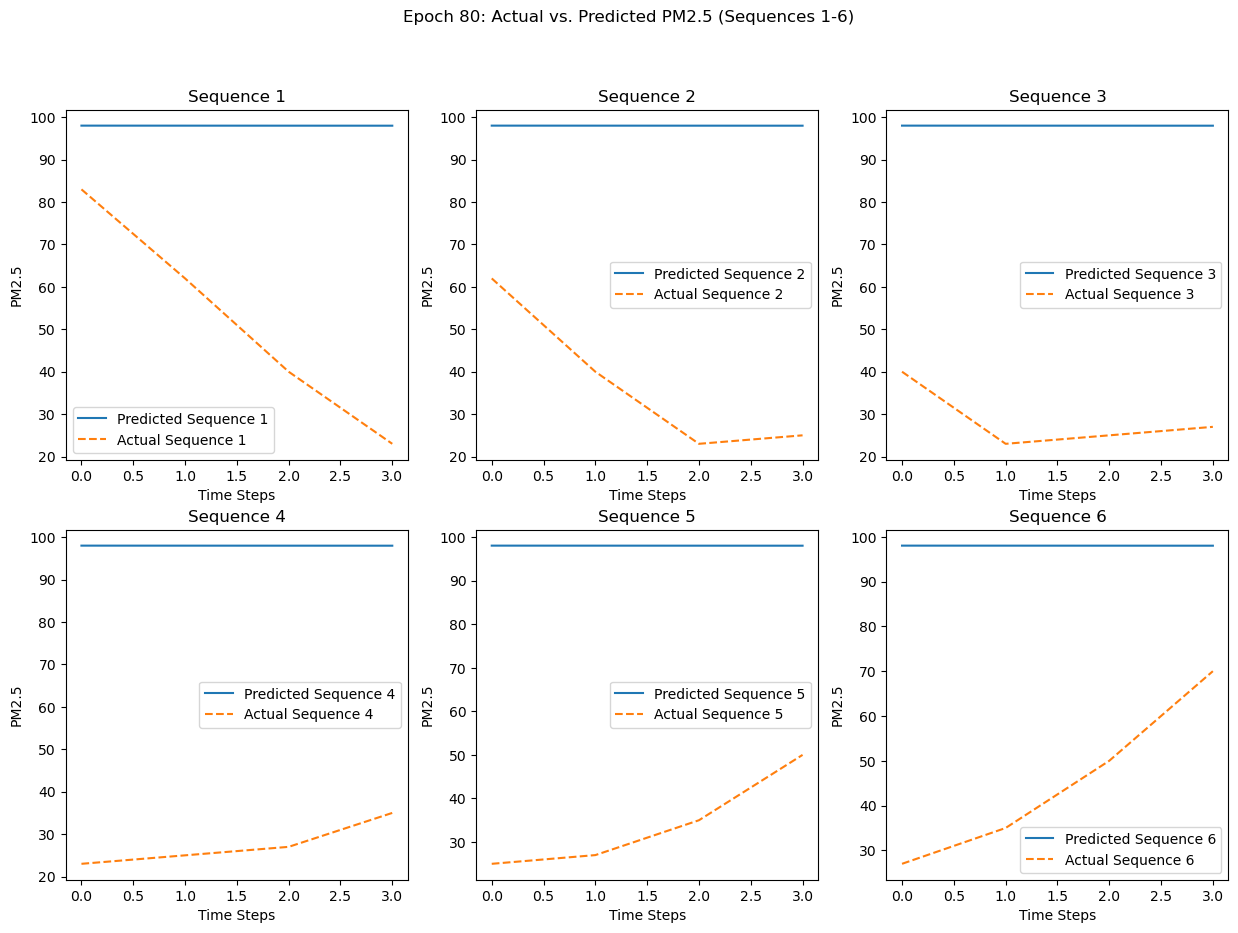

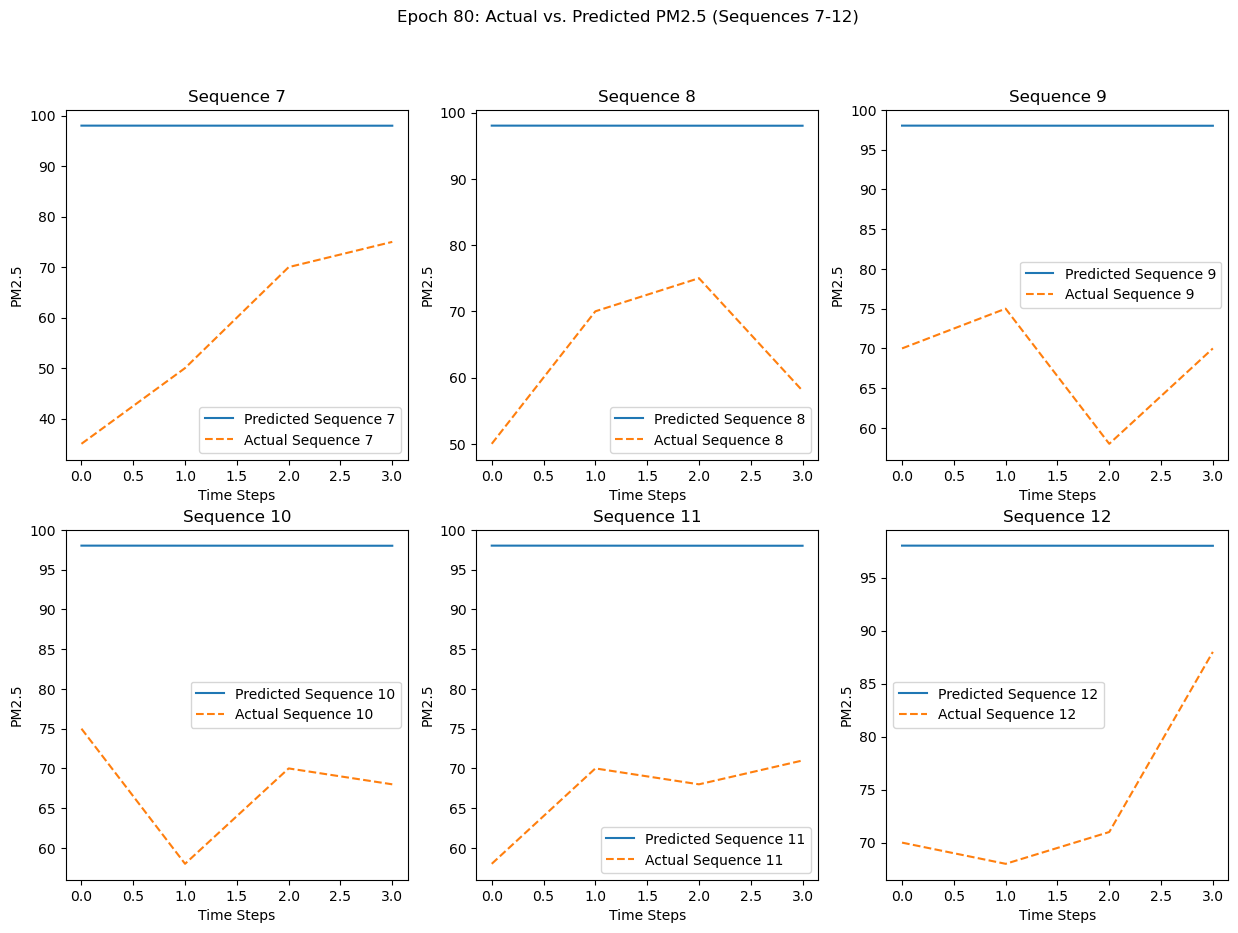

Saved training plots for Epoch 80 in ./Results\LSTMStudy_20241023_132350\Train
Epoch [81/100], Loss: 1.0056
Epoch [82/100], Loss: 1.0056
Epoch [83/100], Loss: 1.0056
Epoch [84/100], Loss: 1.0056
Epoch [85/100], Loss: 1.0056
-- Evaluation after Epoch [85/100], Test Loss: 0.9136
Epoch [86/100], Loss: 1.0056
Epoch [87/100], Loss: 1.0056
Epoch [88/100], Loss: 1.0056
Epoch [89/100], Loss: 1.0056
Epoch [90/100], Loss: 1.0056
-- Evaluation after Epoch [90/100], Test Loss: 0.9136
Epoch [91/100], Loss: 1.0056
Epoch [92/100], Loss: 1.0056
Epoch [93/100], Loss: 1.0056
Epoch [94/100], Loss: 1.0056
Epoch [95/100], Loss: 1.0056
-- Evaluation after Epoch [95/100], Test Loss: 0.9136
Epoch [96/100], Loss: 1.0056
Epoch [97/100], Loss: 1.0056
Epoch [98/100], Loss: 1.0056
Epoch [99/100], Loss: 1.0056
Epoch [100/100], Loss: 1.0056
-- Evaluation after Epoch [100/100], Test Loss: 0.9136


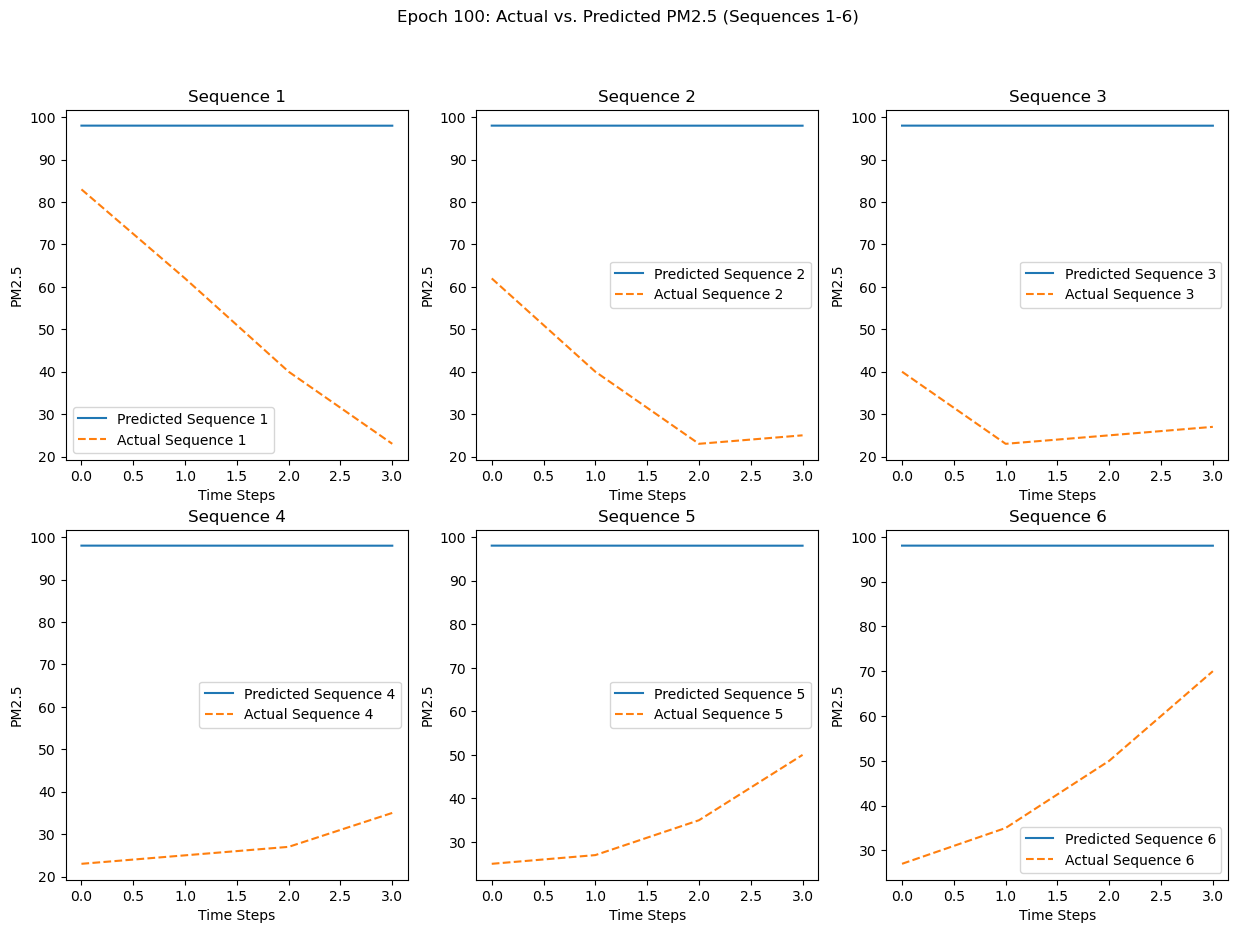

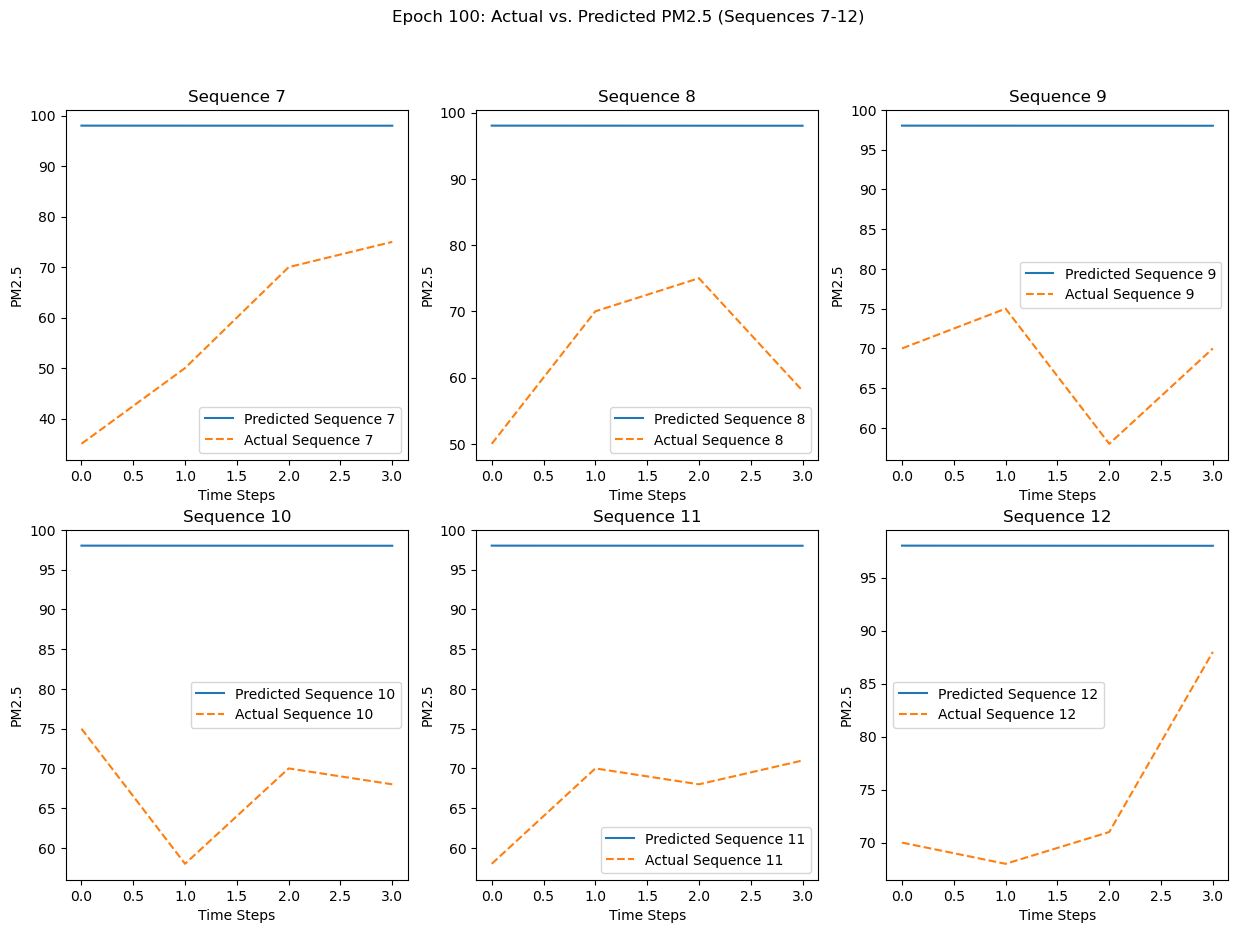

Saved training plots for Epoch 100 in ./Results\LSTMStudy_20241023_132350\Train


In [16]:
#Train the model
num_epochs = params.num_epochs
#num_epochs = 10

# Initialize list to store loss values
loss_values = []
test_losses = []   # Store test loss for each 5th epoch

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for data, labels in train_loader:
        data, labels = data.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)

        # Compute the loss (squeeze the outputs so they match the shape of labels)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Compute average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)  # Store average loss for this epoch

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

    # -------- Testing Phase (every 5 epochs) --------
    if (epoch + 1) % 5 == 0:
        model.eval()  # Set the model to evaluation mode
        running_test_loss = 0.0

        with torch.no_grad():  # Disable gradient calculations for testing
            for data, labels in test_loader:
                data, labels = data.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')

                # Forward pass
                outputs = model(data)

                # Compute the loss
                loss = criterion(outputs, labels)

                running_test_loss += loss.item()

        # Compute average test loss for the epoch
        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        # Print test loss for the current evaluation
        print(f'-- Evaluation after Epoch [{epoch + 1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}')

    # Every 10 epochs, generate plots for the fixed sequences
    if (epoch + 1) % 20 == 0:
        model.eval()  # Switch to evaluation mode for generating predictions
        with torch.no_grad():
            predictions = model(fixed_sequences)

        # Mean and standard deviation of the scaled values
        means = scaler.mean_
        stds = scaler.scale_
        
        # Reverse the standardization to get predictions and actual values in the original scale
        predictions_np = predictions.squeeze(-1).cpu().numpy() * stds[pm_index] + means[pm_index] # Reverse standardization
        #predictions_np = predictions.squeeze(-1).cpu().numpy()
        actual_np = fixed_labels.cpu().numpy() * stds[pm_index] + means[pm_index]
       # actual_np = fixed_labels.cpu().numpy()

         # Create two images, each with 6 subplots
        fig1, axs1 = plt.subplots(2, 3, figsize=(15, 10))  # First image, 2 rows x 3 columns
        fig2, axs2 = plt.subplots(2, 3, figsize=(15, 10))  # Second image, 2 rows x 3 columns
    
        for i in range(6):  # First 6 sequences in the first figure
            ax = axs1[i // 3, i % 3]  # Access subplot in grid
            ax.plot(predictions_np[i], label=f'Predicted Sequence {i+1}')
            ax.plot(actual_np[i], label=f'Actual Sequence {i+1}', linestyle='dashed')
            ax.set_title(f'Sequence {i+1}')
            ax.set_xlabel('Time Steps')
            ax.set_ylabel('PM2.5')
            ax.legend()
    
        for i in range(6, 12):  # Next 6 sequences in the second figure
            ax = axs2[(i - 6) // 3, (i - 6) % 3]  # Access subplot in grid
            ax.plot(predictions_np[i], label=f'Predicted Sequence {i+1}')
            ax.plot(actual_np[i], label=f'Actual Sequence {i+1}', linestyle='dashed')
            ax.set_title(f'Sequence {i+1}')
            ax.set_xlabel('Time Steps')
            ax.set_ylabel('PM2.5')
            ax.legend()
    
        # Display the two images with 6 subplots each
        # Save the figures in the study folder
        fig1_path = os.path.join(train_folder, f'Epoch_{epoch + 1}_Sequences_1-6.png')
        fig2_path = os.path.join(train_folder, f'Epoch_{epoch + 1}_Sequences_7-12.png')
        fig1.suptitle(f'Epoch {epoch + 1}: Actual vs. Predicted PM2.5 (Sequences 1-6)')
        fig2.suptitle(f'Epoch {epoch + 1}: Actual vs. Predicted PM2.5 (Sequences 7-12)')

        fig1.savefig(fig1_path)  # Save the first figure
        fig2.savefig(fig2_path)  # Save the second figure

        plt.show()  # Show the first figure
        plt.show()  # Show the second figure

        plt.close(fig1)  # Close the figure to free memory
        plt.close(fig2)  # Close the figure to free memory

        print(f"Saved training plots for Epoch {epoch + 1} in {train_folder}")
    
        model.train()  # Switch back to training mode

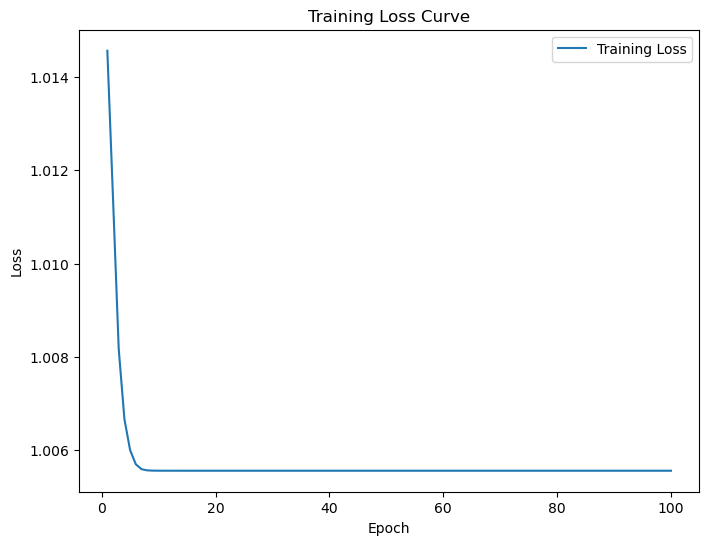

In [17]:
# Plot the loss curve after training
lossfig_path = os.path.join(train_folder, f'loss_curve.png')
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.savefig(lossfig_path) 
plt.show()
plt.close()

In [19]:
# Set the model to evaluation mode
model.eval()

# Initialize a list to store predictions
all_predictions = []
all_actual_labels = []

# Initialize total loss for calculating MSE over the validation set
total_val_loss = 0.0

# Path to save the validation results
val_results_file = os.path.join(val_folder, 'validation_results.txt')

# Make predictions on the validation dataset using the DataLoader
with torch.no_grad():
    for data, labels in val_loader:
        #data_tensor, _ = data  # We only need the features for prediction
        #predictions = model(data_tensor.to('cuda' if torch.cuda.is_available() else 'cpu'))
        data, labels = data.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')

        # Forward pass to get predictions
        predictions = model(data)
        
        # Compute the validation loss (MSE)
        val_loss = criterion(predictions.squeeze(-1), labels)
        
        # Accumulate the total validation loss
        total_val_loss += val_loss.item()
        
        # Store predictions and actual labels for later analysis or metrics calculation
        all_predictions.append(predictions.cpu().numpy())  # Move predictions to CPU and store
        all_actual_labels.append(labels.cpu().numpy())     # Move labels to CPU and store

# Calculate the average MSE over the entire validation set
avg_val_loss = total_val_loss / len(val_loader)
print(f'Validation Loss (MSE): {avg_val_loss:.4f}')

# Concatenate all predictions and actual labels into a single array
val_predictions = np.concatenate(all_predictions, axis=0)
val_actual_labels = np.concatenate(all_actual_labels, axis=0)

# Write the validation loss to a text file
with open(val_results_file, 'w') as f:
    f.write(f'Validation Loss (MSE): {avg_val_loss:.4f}\n')
    f.write(f'Validation Predictions Shape: {val_predictions.shape}\n')
    f.write(f'Validation Actual Labels Shape: {val_actual_labels.shape}\n')

print(f'Validation results saved to: {val_results_file}')        
        
        
       # all_predictions.append(predictions.cpu().numpy())  # Append to list

## Concatenate all predictions into a single array
#val_predictions = np.concatenate(all_predictions, axis=0)

Validation Loss (MSE): 1.2617
Validation results saved to: ./Results\LSTMStudy_20241023_132350\Val\validation_results.txt


In [20]:
# Step 2: Reverse Standardization for Predictions
means = scaler.mean_
stds = scaler.scale_

# Flatten predictions
predictions_np = val_predictions.squeeze(-1)
predictions_original_scale = predictions_np * stds[pm_index] + means[pm_index]  # Assuming PM2.5 is the first column
#predictions_original_scale = predictions_np 
## Step 3: Reverse Standardization for Actual PM2.5 Labels
#actual_labels_np = val_labels_tensor.numpy()
#actual_labels_original_scale = actual_labels_np * stds[pm_index] + means[pm_index]  # Same column assumption

# Step 3: Reverse Standardization for Actual PM2.5 Labels
actual_labels_original_scale = val_actual_labels * stds[pm_index] + means[pm_index]
#actual_labels_original_scale = val_actual_labels 



ValueError: cannot select an axis to squeeze out which has size not equal to one

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display

# Number of sequences to plot
num_sequences = 10

# Loop through the first 10 sequences and create individual plots
for i in range(num_sequences):
    plt.figure(figsize=(14, 7))
    
    # Plot actual PM2.5 values
    plt.plot(actual_labels_original_scale[i], label='Actual PM2.5', color='blue', alpha=0.7)
    
    # Plot predicted PM2.5 values
    plt.plot(predictions_original_scale[i], label='Predicted PM2.5', color='red', alpha=0.7)
    
    # Set title and labels
    plt.title(f'Sequence {i+1}: Predicted vs Actual PM2.5 Values')
    plt.xlabel('Timestep')
    plt.ylabel('PM2.5 Value')
    
    # Show legend and grid
    plt.legend()
    plt.grid(True)
    
    # Display the plot inline
    display(plt.gcf())  # This will display the plot inline in notebooks

     # Save the plot to the 'val_folder' with an appropriate file name
    plot_filename = os.path.join(val_folder, f'sequence_{i+1}_val_plot.png')
    plt.savefig(plot_filename)  # Save figure
    
    # Close the current figure after displaying to avoid overlap
    plt.close()